# Aim
Characterize the SEAL closed-loop delay and try to build that into the controller.


In [56]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import re
sys.path.append("..")
from src import *
fs = 100

In [3]:
def stamp_to_seconds(t):
    h, m, s, ms = [int(x) for x in re.search("(\d+):(\d+):(\d+),(\d+)", t).groups()]
    return 3600 * h + 60 * m + s + 0.001 * ms

In [91]:
exposures = []
states = []
dmcs = []
for fname in ["41_19", "41_37", "41_54", "49_27"]:
    with open(joindata("log", f"log_12_11_2021_09_{fname}.log")) as file:
        for line in file:
            time = re.search("\d+:\d+:\d+,\d+", line)[0]
            seconds = stamp_to_seconds(time)
            event = re.search("INFO \| (.+)", line)[1]
            if event.startswith("Exposure"):
                exposures.append(seconds)
            elif event.startswith("state"):
                states.append(seconds)
            elif event.startswith("DMC"):
                dmcs.append(seconds)

t0 = exposures[0]
exposures = np.array(exposures) - t0
states = np.array(states) - t0
dmcs = np.array(dmcs) - t0

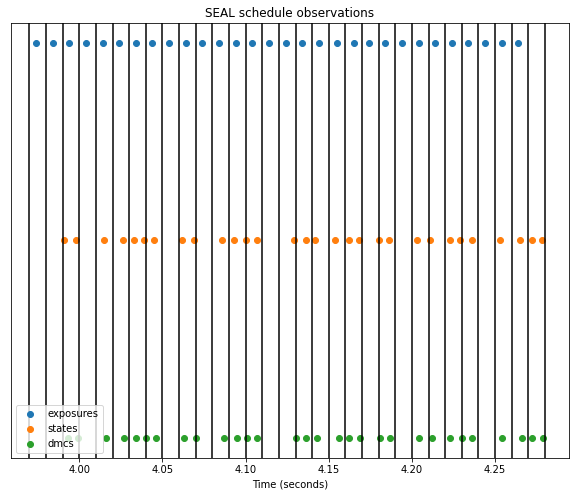

In [92]:
nstart = 400
npoints = 30
plt.figure(figsize=(10,8))
plt.scatter(exposures[nstart:nstart+npoints], 1.5*np.ones_like(exposures[nstart:nstart+npoints]), label="exposures")
plt.scatter(states[nstart:nstart+npoints], np.ones_like(states[nstart:nstart+npoints]), label="states")
plt.scatter(dmcs[nstart:nstart+npoints], 0.5*np.ones_like(dmcs[nstart:nstart+npoints]), label="dmcs")
min_time = exposures[nstart]
max_time = dmcs[nstart+npoints-1]
for v in np.arange(np.round(min_time, decimals=2), np.round(max_time, decimals=2)+0.01, 0.01):
    plt.axvline(v, color='k')
plt.title("SEAL schedule observations")
plt.xlabel("Time (seconds)")
plt.yticks([])
plt.legend()

In [106]:
if len(exposures) > len(states):
    diff = len(exposures) - len(states)
    means = np.zeros(diff)
    for i in range(diff):
        means[i] = np.mean(states - exposures[i:i+len(states)])
    means[means < 0] = np.inf
    offset = np.argmin(means)
    measure_delays = (states - exposures[offset:offset+len(states)]) * fs
    num_meas_bins = int(max(measure_delays) * 1000 / fs) + 1
    control_delays = (dmcs - states) * fs
    num_cont_bins = int(max(control_delays) * 1000 / fs) + 1

Text(0.5, 1.0, 'Controller frame delay')

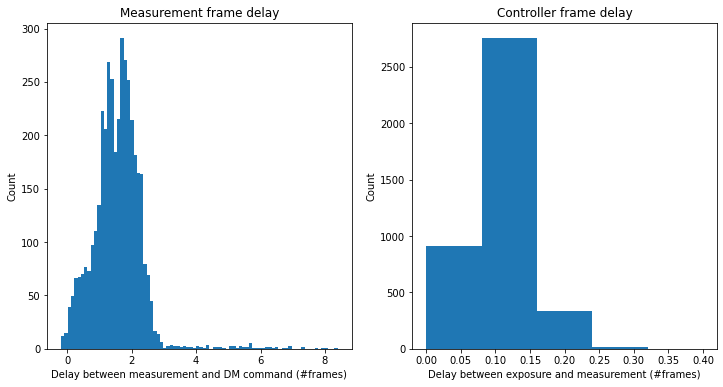

In [108]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].hist(measure_delays, bins=num_meas_bins);
axs[0].set_xlabel("Delay between measurement and DM command (#frames)")
axs[0].set_ylabel("Count")
axs[0].set_title("Measurement frame delay")
axs[1].hist(control_delays, bins=num_cont_bins);
axs[1].set_xlabel("Delay between exposure and measurement (#frames)")
axs[1].set_ylabel("Count")
axs[1].set_title("Controller frame delay")